In [ ]:
import fitz
import os

dpi = 300
zoom = dpi / 72
magnify = fitz.Matrix(zoom, zoom)

path = "financial_report.pdf"
output_dir = "./images"
os.makedirs(output_dir, exist_ok=True)

doc = fitz.open(path)

for count, page in enumerate(doc, start=1):
    pix = page.get_pixmap(matrix=magnify)
    pix.save(os.path.join(output_dir, f"JP_page_{count}.png"))


In [1]:
#!pip install -q transformers
!pip install -q easyocr

In [2]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

In [4]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("")

In [6]:
from PIL import Image

file_path = r"C:\PROJECTS\pdf_layout_analysis\JP_page_3.png"

image = Image.open(file_path).convert("RGB")

width, height = image.size

resized_image = image.resize((int(0.6*width), int(0.6*height)))


In [7]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
pixel_values = detection_transform(image).unsqueeze(0)
#pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 618])


In [9]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [10]:
outputs.logits.shape

torch.Size([1, 15, 3])

In [11]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [12]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [13]:
print(objects)

[{'label': 'table', 'score': 0.9998847246170044, 'bbox': [241.96319580078125, 291.9028015136719, 2351.429931640625, 873.8551635742188]}]


In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    for det_table in det_tables:
        bbox = det_table['bbox']

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

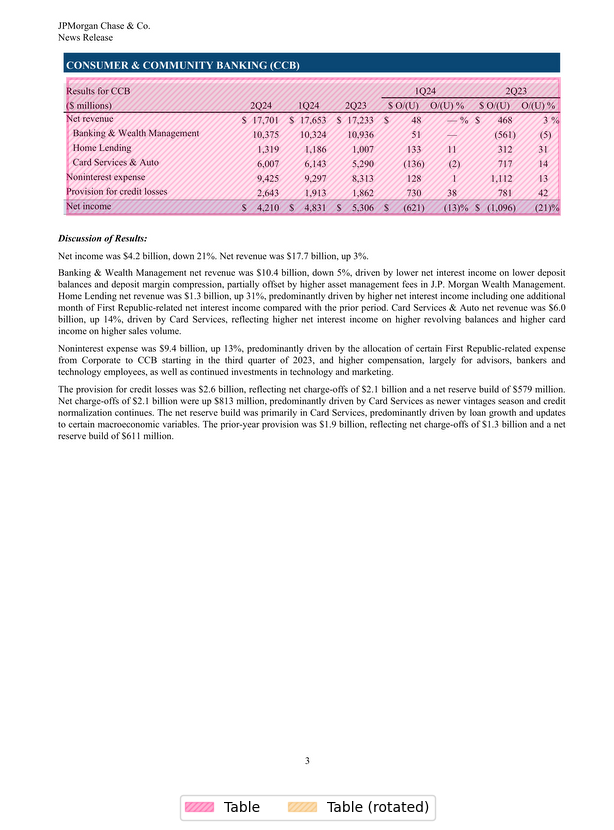

In [15]:
fig = visualize_detected_tables(image, objects)

In [16]:
visualized_image = fig2img(fig)

In [17]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0]-padding, bbox[1]-padding, bbox[2]+padding, bbox[3]+padding]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [token['bbox'][0]-bbox[0],
                             token['bbox'][1]-bbox[1],
                             token['bbox'][2]-bbox[0],
                             token['bbox'][3]-bbox[1]]
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [18]:
objects

[{'label': 'table',
  'score': 0.9998847246170044,
  'bbox': [241.96319580078125,
   291.9028015136719,
   2351.429931640625,
   873.8551635742188]}]

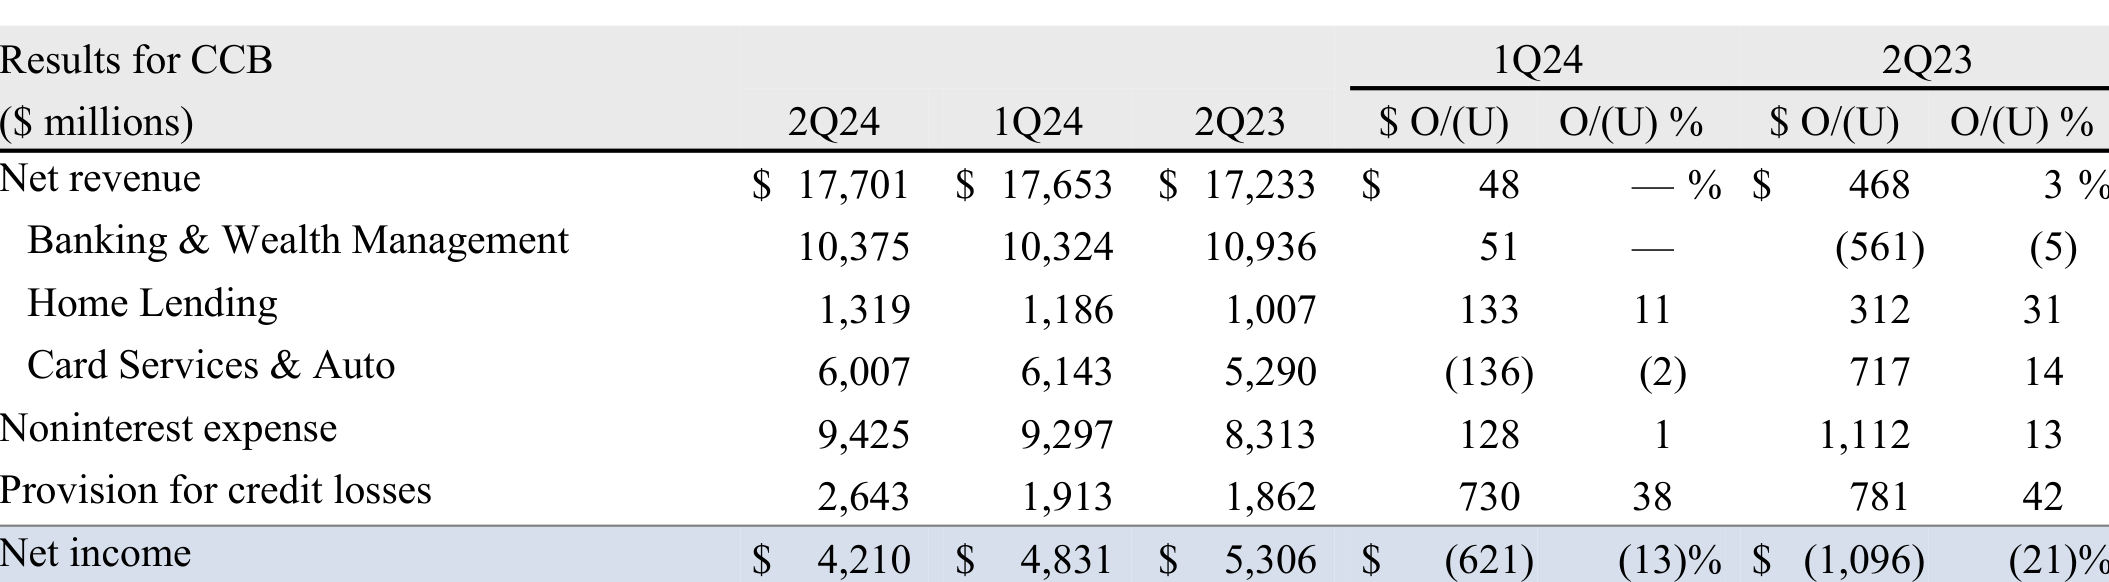

In [19]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 10

tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [20]:
cropped_table.save("table.jpg")

In [21]:
from transformers import TableTransformerForObjectDetection
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [23]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 276, 1000])


In [24]:
with torch.no_grad():
  outputs = structure_model(pixel_values)

In [25]:
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9999022483825684, 'bbox': [659.0427856445312, 35.19328689575195, 929.4656982421875, 581.92529296875]}, {'label': 'table row', 'score': 0.9997127652168274, 'bbox': [0.16033825278282166, 211.75115966796875, 2108.6552734375, 274.0240783691406]}, {'label': 'table spanning cell', 'score': 0.9899779558181763, 'bbox': [931.8045654296875, 35.175662994384766, 1137.555419921875, 149.7633819580078]}, {'label': 'table spanning cell', 'score': 0.9977824091911316, 'bbox': [0.6607431769371033, 35.18157958984375, 658.2461547851562, 150.1317138671875]}, {'label': 'table column', 'score': 0.9999496936798096, 'bbox': [1737.481201171875, 35.403282165527344, 1941.081787109375, 581.7416381835938]}, {'label': 'table spanning cell', 'score': 0.993913471698761, 'bbox': [658.5634765625, 35.26455307006836, 932.3565673828125, 149.33523559570312]}, {'label': 'table column header', 'score': 0.9966142773628235, 'bbox': [0.2189173400402069, 35.061370849609375, 2108.77099609375, 1

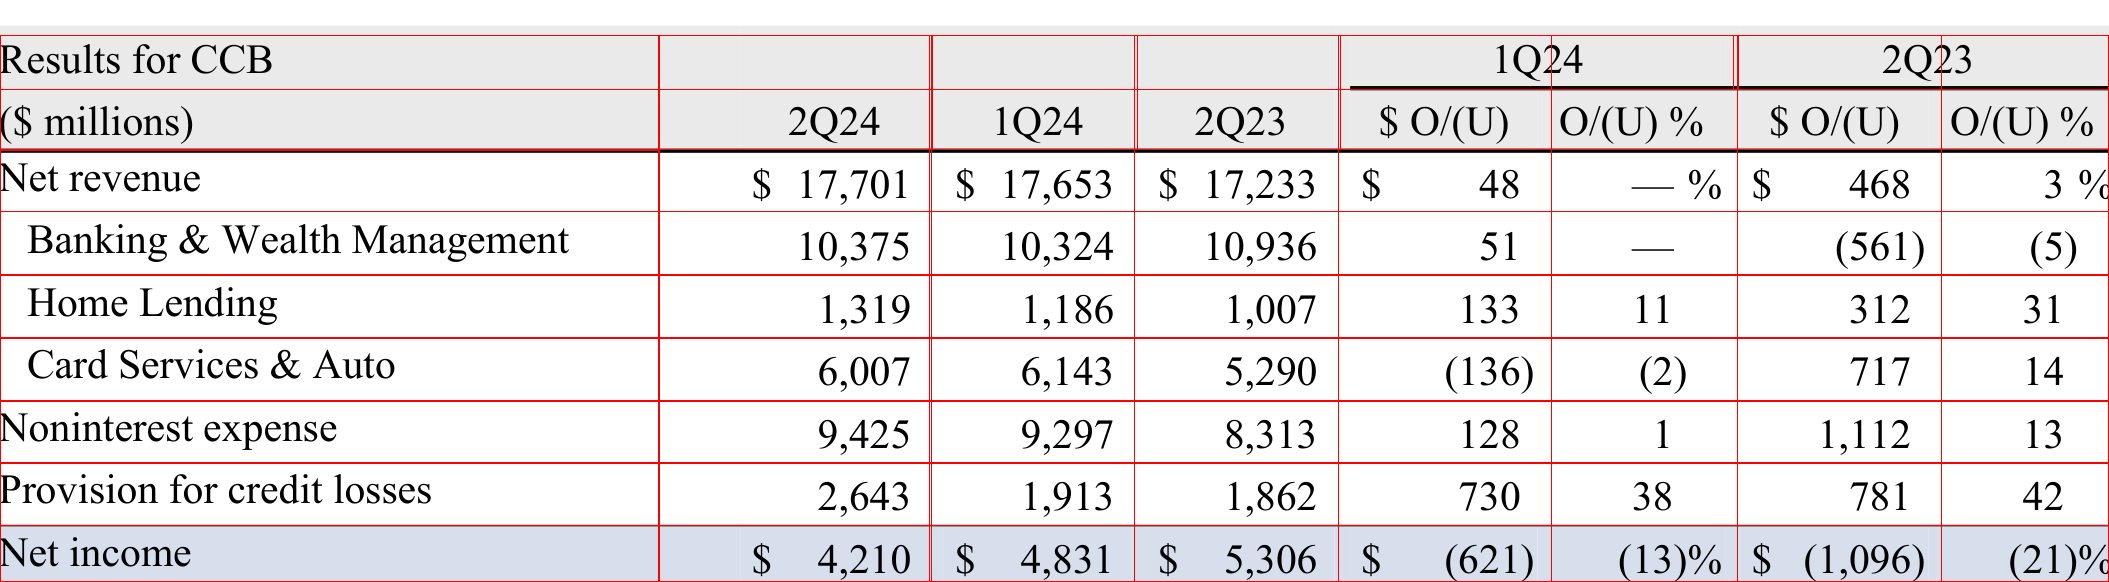

In [26]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [27]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

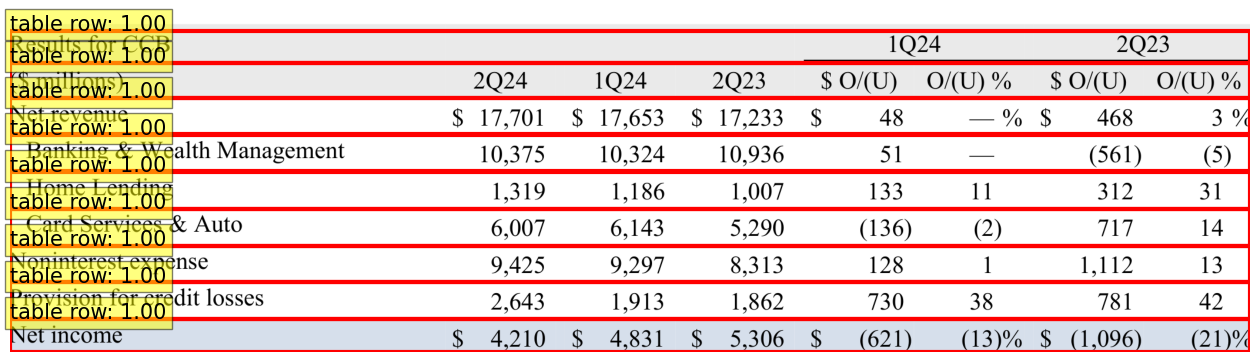

In [28]:
plot_results(cells, class_to_visualize="table row")

In [29]:
def get_cell_coordinates_by_row(table_data):
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})
        row_cells.sort(key=lambda x: x['column'][0])
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [30]:
len(cell_coordinates)

9

In [31]:
len(cell_coordinates[0]["cells"])

8

In [32]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [-0.31281986832618713, 35.0937614440918, 658.528076171875, 581.8070068359375], 'cell': [-0.31281986832618713, 35.1535758972168, 658.528076171875, 89.28558349609375]}, {'column': [659.0427856445312, 35.19328689575195, 929.4656982421875, 581.92529296875], 'cell': [659.0427856445312, 35.1535758972168, 929.4656982421875, 89.28558349609375]}, {'column': [931.8604125976562, 35.17802429199219, 1134.717041015625, 581.8682250976562], 'cell': [931.8604125976562, 35.1535758972168, 1134.717041015625, 89.28558349609375]}, {'column': [1134.6695556640625, 35.23405075073242, 1338.082275390625, 581.9571533203125], 'cell': [1134.6695556640625, 35.1535758972168, 1338.082275390625, 89.28558349609375]}, {'column': [1338.57861328125, 35.19703674316406, 1551.245361328125, 581.6497802734375], 'cell': [1338.57861328125, 35.1535758972168, 1551.245361328125, 89.28558349609375]}, {'column': [1551.2342529296875, 35.080806732177734, 1737.8050537109375, 581.7417602539062], 'cell': [1551.2342529296875, 35

In [33]:
pip install easyocr

Note: you may need to restart the kernel to use updated packages.


In [34]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) 

def apply_ocr(cell_coordinates):
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

100%|██████████| 9/9 [00:06<00:00,  1.48it/s]

Max number of columns: 8
['Results for CCB', '1Q2', '24', '2Q3', '23', '', '', '']
['(S millions _', '2Q24', '1Q24', '2023', '$ O/(U)', 'O/(U) %', '$ O/(U)', 'O/(U) %']
['Net revenue', '$ 17,701', 'S 17,653', 'S 17,233', 'S 48', 'S 468', '3 %', '']
['Banking & Wealth Management', '10,375', '10,324', '10,936', '51', '(561)', '', '']
['Home Lending', '1,319', '1,186', '1,007', '133', '11', '312', '31']
['Card Services & Auto', '6,007', '6,143', '5,290', '(136)', '717', '14', '']
['Noninterest expense', '9,425', '9,297', '8,313', '128', '1', '1,112', '13']
['Provision for credit losses', '2,643', '1,913', '1,862', '730', '38', '781', '42']
['Net income', 'S 4,210', 'S 4,831', 'S 5,306', 'S (621)', '13)%', '(1,096)', '(21)%']


## Save as CSV

We end up with a CSV file containing the data.

In [35]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [36]:
import pandas as pd

df = pd.read_csv("output.csv")
df.head()

,Results for CCB,1Q2,24,2Q3,23,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,(S millions _,2Q24,1Q24,2023,$ O/(U),O/(U) %,$ O/(U),O/(U) %
1,Net revenue,"$ 17,701","S 17,653","S 17,233",S 48,S 468,3 %,NaN
2,Banking & Wealth Management,"10,375","10,324","10,936",51,(561),NaN,NaN
3,Home Lending,"1,319","1,186","1,007",133,11,312,31
4,Card Services & Auto,"6,007","6,143","5,290",(136),717,14,NaN
